In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

# Package imports

In [2]:
# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(18,10),dpi=100)
%matplotlib inline

# Numba (JiT)
from numba import njit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

#  Function that creates directories if they don't exist

In [3]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Defining the velocity field

In [4]:
@njit
def doublegyre_wrapper(t,x):
    # Parameters of the velocity field (Cf. Farazmand & Haller, 2012)
    # A
    A = 0.1
    # epsilon
    e = 0.1
    # omega
    w = 2*np.pi/10
    return _doublegyre(t,x,A,e,w)

@njit
def _doublegyre(t,x,A,e,w):
    # a(t)
    a = e * np.sin(w*t)       
    # b(t)
    b = 1 - 2*e*np.sin(w*t)  
    # f(x,t)
    f = a*x[0,:]**2 + b*x[0,:]
    # df/dx
    dfdx = 2*a*x[0,:] + b
    
    v = np.empty(x.shape)                         
    # x-component:
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:])
    # y-component:
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*dfdx
    return v 

# Functions which generate grids of particles

In [5]:
def grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x = np.linspace(x_min,x_max,nx)
    y = np.linspace(y_min,y_max,ny)
    
    grid = np.empty((2,nx*ny))
    
    for j in range(nx):
        grid[0,j*ny:(j+1)*ny] = x[j]
        grid[1,j*ny:(j+1)*ny] = y
        
    return grid

def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid   

# List of implemented fixed step integrators
## Relevant for saving/loading advected states

In [6]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function which advects a set of initial conditions, including auxiliary grid points

In [7]:
# Input: (numpy) array of coordinates, shape: (5,2,nx*ny), [grid,x,y]
def endpoints(t_start,t_end,pos_start,stride,integrator,rhs,n_proc,atol,rtol):
    pos_end = np.empty(pos_start.shape)
    
    n_tot = pos_start.shape[2]
    
    div = np.floor(np.linspace(0,n_tot,n_proc+1)).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    
    if integrator.__name__ in fixed_step_integrators:
        plist = [mp.Process(target=_endpoints_fixed,
                           args=(t_start,t_end,pos_start[:,:,div[j]:div[j+1]],
                                stride,integrator,rhs,j,qlist[j])) for j in range(n_proc)]
    else:
        plist = [mp.Process(target=_endpoints_adaptive,
                           args=(t_start,t_end,pos_start[:,:,div[j]:div[j+1]],
                                stride,integrator,rhs,j,qlist[j],atol,rtol)) for j in range(n_proc)]
    
    for p in plist:
        p.start()
    for j, q in enumerate(qlist):
        pos_end[:,:,div[j]:div[j+1]] = q.get()
    for p in plist:
        p.join()
    
    return pos_end

def _endpoints_fixed(t_start,t_end,pos_start,stride,integrator,rhs,pn,q):
    pos_fin = np.copy(pos_start)
    if t_end>t_start:
        for j in range(pos_fin.shape[0]):
            n_steps = np.ceil((t_end-t_start)/stride).astype(int)
            h = (t_end-t_start)/n_steps
            for i in range(n_steps):
                foo, pos_fin[j], bar = integrator(t_start+i*h, pos_fin[j], h, rhs)
            #t = np.copy(t_start).astype(np.float64)
            #h = np.copy(stride).astype(np.float64)
            #while t<t_end:
            #    h = np.minimum(h,t_end-t)
            #    t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    else:
        for j in range(np.size(pos_fin,0)):
            n_steps = np.ceil((t_start-t_end)/stride).astype(int)
            h = -(t_start-t_end)/n_steps
            for i in range(n_steps):
                foo, pos_fin[j], bar = integrator(t_start+i*h, pos_fin[j], h, rhs)
            #t = np.copy(t_start).astype(float)
            #h = np.copy(stride).astype(float)
            #while t>t_end:
            #    h=np.sign(h)*np.minimum(np.abs(h),np.abs(t-t_end))
            #    t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    q.put(pos_fin)
    
def _endpoints_adaptive(t_start,t_end,pos_start,stride,integrator,rhs,pn,q,atol,rtol):
    pos_fin = np.copy(pos_start)
    n_calls = np.zeros((5,pos_fin.shape[2]),dtype=int)
    if t_end>t_start:
        for j in range(np.size(pos_fin,0)):
            t = np.ones(np.shape(pos_fin[j])[1])*t_start
            h = np.ones(np.shape(pos_fin[j])[1])*stride
            while np.any(np.less(t,t_end)):
                mask = np.less(t,t_end)
                h[mask] = np.minimum(h[mask],t_end-t[mask])
                t[mask],pos_fin[j][:,mask],h[mask] = integrator(t[mask],pos_fin[j][:,mask],h[mask],rhs,atol,rtol)
                n_calls[j,mask]+=1
    else:
        for j in range(np.size(pos_fin,0)):
            t = np.ones(np.shape(pos_fin[j])[1])*t_start
            h = np.ones(np.shape(pos_fin[j])[1])*stride
            while np.any(t>t_end):
                mask = np.greater(t,t_end)
                h[mask] = np.sign(h[mask])*np.minimum(np.abs(h[mask]),np.abs(t[mask]-t_end))
                t[mask],pos_fin[j][:,mask],h[mask] = integrator(t[mask],pos_fin[j][:,mask],h[mask],rhs,atol,rtol)
                n_calls[j,mask]+=1
    msteps = [np.mean(n_calls[j]) for j in range(5)]
    q.put(pos_fin)
    print('Processs {}: n_particles = {}, n_calls = {}, {}, {}, {}, {}'.format(pn,pos_fin.shape[2],msteps[0],msteps[1],msteps[2],msteps[3],msteps[4]))

# Function which computes the characteristics for given grid parameters

In [11]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,rhs,n_proc=4,atol=None,rtol=None):
    if atol is None:
        atol = 1.e-8
    if rtol is None:
        rtol = 1.e-8
    
    grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,n_proc,atol,rtol)
    
    return grid,lmbd1,lmbd2,hess_lmbd2,xi1,xi2

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,n_proc,atol,rtol):
    if integrator.__name__ in fixed_step_integrators:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found! Advection necessary!')
            # Grid: Main -> Right -> Above -> Left -> Beneath
            grid = np.empty((5,2,(nx+4)*(ny+4)))
            grid[0] = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
            grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
            grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
            grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
            grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
            
            grid = endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)
            np.save('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride),grid)
            print('Configuration now stored. Advection won\'t be necessary next time!')
    else:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found! Advection necessary!')
            tic = time.time()
            # Grid: Main -> Right -> Above -> Left -> Beneath
            grid = np.zeros((5,2,(nx+4)*(ny+4)))
            grid[0] = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
            grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
            grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
            grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
            grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
            
            grid = endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)
            np.save('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol),grid)
            mins,secs = np.divmod(time.time()-tic,60)
            print('Advection took {} minutes and {} seconds.\nConfiguration now stored. Advection won\'t be necessary next time!'.format(mins,secs))        
    
    tic = time.time()                              
    
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    hess_lmbd2 = _find_hessian(lmbd2,nx,ny,dx_main,dy_main)
                
    mins,secs = np.divmod(time.time()-tic,60)
    
    print('Characteristics calculated in {} minutes and {} seconds'.format(mins,secs))        
    
    return lmbd1,lmbd2,hess_lmbd2,xi1,xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((nx+4,ny+4,2,2))
    df_a = np.empty((nx+4,ny+4,2,2))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[:,:,0,0] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[:,:,0,1] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[:,:,1,0] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[:,:,1,1] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[1:-1,:,0,0] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,:,0,0] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[-1,:,0,0] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,0,1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[:,0,0,1] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[:,-1,0,1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1:-1,:,1,0] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[0,:,1,0] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[-1,:,1,0] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,1,1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[:,0,1,1] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[:,-1,1,1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape(((nx+4)*(ny+4),2,2))
    df_m = df_m.reshape(((nx+4)*(ny+4),2,2))
    
    # Calculate strain tensors:
    c_m = np.matmul(np.transpose(df_m,axes=(0,2,1)),df_m)
    c_a = np.matmul(np.transpose(df_a,axes=(0,2,1)),df_a)
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    
    vals = np.linalg.eigvalsh(tens_main)
    bar, vecs = np.linalg.eigh(tens_aux)
    
    lmbd1 = vals[:,0]
    lmbd2 = vals[:,1]
    
    xi1 = vecs[:,:,0]
    xi2 = vecs[:,:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_hessian(lmbd_,nx,ny,dx_main,dy_main):
    lmbd = lmbd_.reshape((nx+4,ny+4))
    
    hessian = np.empty((nx+4,ny+4,2,2))
    
    # First, the laplacian terms:
    
    # Internal points: Centered differences
    hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dx_main**2)
    hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dy_main**2)
    
    # Near boundaries: Higher order forwards/backwards differences
    hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dx_main**2)
    hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dx_main**2)
    
    hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dy_main**2)
    hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dy_main**2)
    
    # Then, the mixed derivatives:
    dldx = np.empty((nx+4,ny+4))
    dldy = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dx_main)
    dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dx_main)
    dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dx_main)
    
    dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dy_main)
    dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dy_main)
    
    # Same deal for the mixed derivatives
    d2ldxdy = np.empty((nx+4,ny+4))
    d2ldydx = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dx_main)
    d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dx_main)
    d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dx_main)
    
    d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dy_main)
    d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dy_main)
    
    hessian[:,:,0,1] = d2ldxdy
    hessian[:,:,1,0] = d2ldydx
    
    return hessian.reshape((nx+4)*(ny+4),2,2)
    

# Define transport parameters

In [12]:
from numerical_integrators.adaptive_step import rkbs32
from numerical_integrators.singlestep import rk4
t_start = 0.
t_end = 20.
h = 0.1

integrator = rkbs32
#integrator = rk4

# Create output directory for precomputed characteristics, if it does not already exist:
ensure_path_exists('precomputed_advection/{}'.format(integrator.__name__))



x_min,x_max = 0,2
y_min,y_max = 0,1

nx,ny = 1000,500

# Perform transport

In [13]:
grid_,lmbd1_,lmbd2_,hess_lmbd2_,xi1_,xi2_ = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,h,doublegyre_wrapper)

_inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
_inner_mask[2:-2,2:-2] = True
_inner_mask = _inner_mask.reshape((nx+4)*(ny+4))

grid = grid_[:,_inner_mask]
x_ = grid_[0,::ny+4]
y_ = grid_[1,:ny+4]
x = x_[2:-2]
y = y_[2:-2]
lmbd1 = lmbd1_[_inner_mask]
lmbd2 = lmbd2_[_inner_mask]
hess_lmbd2 = hess_lmbd2_[_inner_mask,:,:]
xi1 = xi1_[_inner_mask,:]
xi2 = xi2_[_inner_mask,:]

Precomputed advection not found! Advection necessary!
Processs 1: n_particles = 126504, n_calls = 4223.0, 4223.0, 4223.0, 4223.0, 4223.0
Processs 2: n_particles = 126504, n_calls = 4269.0, 4269.0, 4269.0, 4269.0, 4269.0
Processs 0: n_particles = 126504, n_calls = 4457.0, 4457.0, 4457.0, 4457.0, 4457.0
Processs 3: n_particles = 126504, n_calls = 4221.0, 4221.0, 4231.0, 4221.0, 4231.0
Advection took 81.0 minutes and 25.2001314163208 seconds.
Configuration now stored. Advection won't be necessary next time!
Characteristics calculated in 0.0 minutes and 3.000532388687134 seconds


# Functions for identifying (A,B)-domain

In [31]:
def find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2):
    return np.logical_and(_a_true(lmbd1,lmbd2),_b_true(hess_lmbd2,xi2))

def _a_true(lmbd1,lmbd2):
    return np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

def _b_true(hess_lmbd2,xi2):
    tf = np.zeros(hess_lmbd2.shape[0],dtype=np.bool)
    #for j in range(len(tf)):
    #    if np.dot(xi2[j],np.dot(hess_lmbd2[j],xi2[j])) <=0:
    #        tf[j] = True
    #return tf
    return np.less_equal(np.sum(xi2*np.sum(hess_lmbd2*xi2[...,np.newaxis],axis=1),axis=1),0)

# Find (A,B)-domain

In [32]:
mask_ab = find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2)

# Plot (A,B)-domain

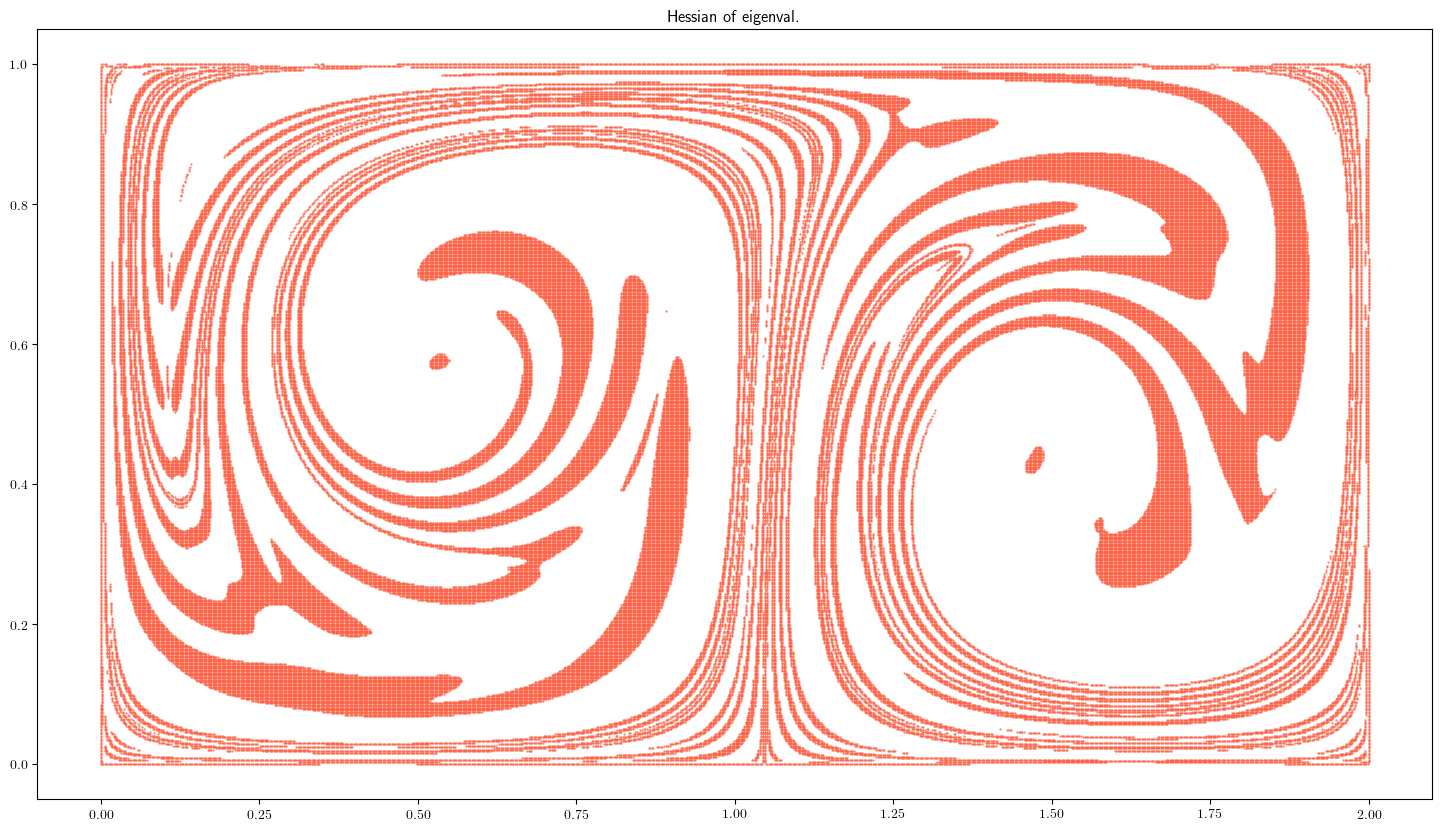

In [33]:
plt.figure()
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],s=1,marker='.',c='tomato')
plt.title('Hessian of eigenval.')
#plt.xlim(0.5,1)
#plt.ylim(0.8,1)

In [34]:
grid[:,mask_ab].shape

(2, 137825)

# Function which finds $\mathcal{G}_0$

In [105]:
def find_g0(nx,ny,num_horz,num_vert):
    mask = np.zeros((nx,ny),dtype=bool)
    stride_horz = np.floor(nx/(num_horz+1)).astype(int)
    stride_vert = np.floor(ny/(num_vert+1)).astype(int)
    
    for j in range(1,num_vert+1):
        mask[np.minimum(j*stride_horz,nx-1),:] = True
    for j in range(1,num_horz+1):
        mask[:,np.minimum(j*stride_vert,ny-1)] = True
    
    mask = mask.reshape(nx*ny)
    
    return mask

# Choose no. of vert. and horz. lines in $\mathcal{G}_{0}$

In [106]:
num_horz_g0 = 4
num_vert_g0 = 4

# Find $\mathcal{G}_0$

In [107]:
g0 = grid[:,np.logical_and(find_g0(nx,ny,num_horz_g0,num_vert_g0),mask_ab)]

# Plot $\mathcal{G}_0$

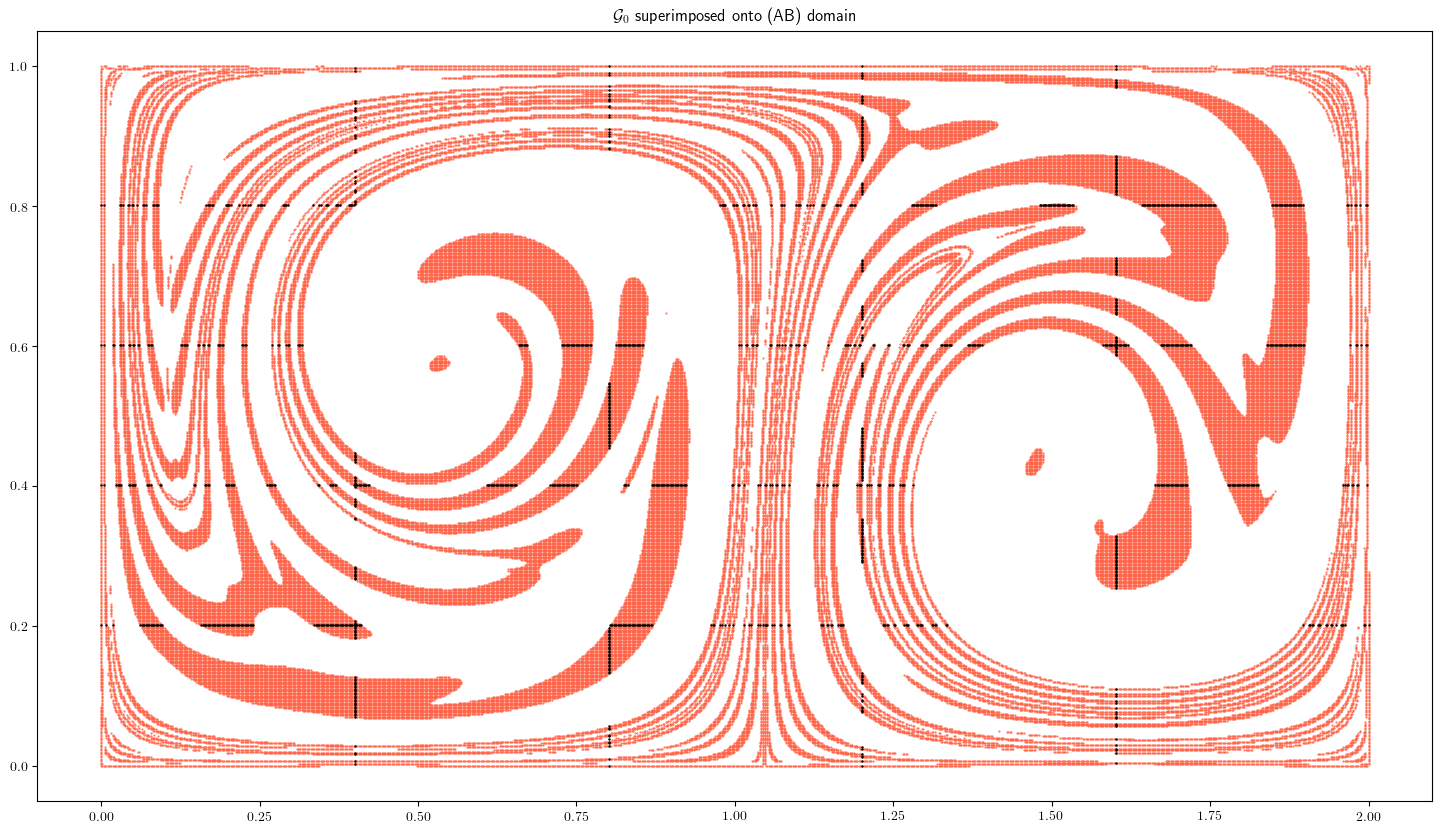

In [108]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],marker='.',s=1,c='tomato')
plt.scatter(g0[0],g0[1],marker='.',s=2,c='k')
plt.title(r'$\mathcal{G}_{0}$ superimposed onto (AB) domain')

# Functions returning derivatives and evaluating whether or not a point is within the numerical definition domain, as well as the (A,B)-domain

In [109]:
class LinearSpecialDerivative:
    def __init__(self,grid,xi):
        self.grid = grid
        self.dx = self.grid[0,1,0]-self.grid[0,0,0]
        self.dy = self.grid[1,0,1]-self.grid[1,0,0]
        self.xi = xi
        self.prev = None
        #self.reverse = False
    def clear_previous(self):
        self.prev = None
    def set_previous(self,prev):
        self.prev = prev
    #def flip(self):
    #    self.reverse = True
    #def flip_back(self):
    #    self.reverse = False
    def __call__(self,pos):
        
        pos[0] = np.maximum(x_min-self.dx,np.minimum(pos[0],x_max+self.dx))
        pos[1] = np.maximum(y_min-self.dy,np.minimum(pos[1],y_max+self.dy))
        #if pos[0] > x_max + self.dx:
        #    pos[0] = x_max + self.dx
        #elif pos[0] < x_min - self.dx:
        #    pos[0] = x_min - self.dx
        
        #if pos[1] > y_max + self.dy:
        #    pos[1] = y_max + self.dy
        #elif pos[1] < y_min - self.dy:
        #    pos[1] = y_min - self.dy
        
        i = int(np.maximum(0,np.minimum(pos[0]/self.dx,np.size(self.grid,1)-2)))
        j = int(np.maximum(0,np.minimum(pos[1]/self.dy,np.size(self.grid,2)-2)))

        
        subxi = self.xi[i:i+2,j:j+2]

        # Choose pivot vector and fix directions of others based on this one
        for ii in range(2):
            for jj in range(2):
                if ii == 0 and jj == 0:
                    pass
                else:
                    dp = np.sign(np.dot(subxi[0,0],subxi[ii,jj]))
                    if dp < 0:
                        subxi[ii,jj] = - subxi[ii,jj]
                    #subxi[:,ii,jj] = np.sign(np.dot(subxi[:,0,0],subxi[:,ii,jj])) * subxi[:,ii,jj]
                    
        wr = (pos[0]-i*self.dx)/self.dx
        wl = 1-wr
        wt = (pos[1]-j*self.dy)/self.dy
        wb = 1-wt
        
        xi = wl*(wb*subxi[0,0]+wt*subxi[0,1])+wr*(wb*subxi[1,0]+wt*subxi[1,1])
        # Normalize xi
        xi = xi / np.sqrt(xi[0]**2+xi[1]**2)
        
        if self.prev is None:
            #if not self.reverse:
            sign = 1.
            #else:
            #    sign = -1.
        else:
            sign = -1. if np.sign(np.dot(self.prev,xi)) < 0 else 1.
        return sign*xi
    
class InABDomain:
    def __init__(self,pos_init,lmbd1,lmbd2,hess_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_xx_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,0,0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_xy_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,0,1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_yx_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,1,0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_yy_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,1,1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[:,:,0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[:,:,1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        
    def __call__(self,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        hess = np.array([[self._hess_lmbd2_xx_spline.ev(pos[1],pos[0]),self._hess_lmbd2_xy_spline.ev(pos[1],pos[0])],[self._hess_lmbd2_yx_spline.ev(pos[1],pos[0]),self._hess_lmbd2_yy_spline.ev(pos[1],pos[0])]])
        xi2 = np.array([self._xi2_x_spline.ev(pos[1],pos[0]),self._xi2_y_spline.ev(pos[1],pos[0])])
        #xi2 = xi2/np.sqrt(xi2[0]**2+xi2[1]**2)
        return ((lmbd1 != lmbd2) and (lmbd2 > 1) and np.less_equal(np.dot(xi2,np.dot(hess,xi2)),0))

class InNumericalDomain:
    def __init__(self,x_min,x_max,y_min,y_max,nx,ny):
        dx = (x_max-x_min)/(nx-1)
        dy = (y_max-y_min)/(ny-1)
        self._x_min = x_min-dx
        self._x_max = x_max+dx
        self._y_min = y_min-dy
        self._y_max = y_max+dx
    
    def __call__(self,pos):
        return pos[0] >= self._x_min and pos[0] <= self._x_max and pos[1] >= self._y_min and pos[1] <= self._y_max
    
class Alpha:
    def __init__(self,lmbd1_spline,lmbd2_spline):
        self.lmbd1_spline = lmbd1_spline
        self.lmbd2_spline = lmbd2_spline
    def __call__(self,pos):
        lmbd1 = self.lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self.lmbd2_spline.ev(pos[1],pos[0])
        return ((lmbd2-lmbd1)/(lmbd2+lmbd1))**2

# Class definition for the Strainline class

In [180]:
class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
        self.tailcut_start = 0
        self.tailcut_end = 0
    def long_enough(self):
        return self.len >= self.l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def traj(self):
        return self.pos
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1],self.pos[0]))
    def lngth(self):
        return np.sum(np.sqrt((np.diff(self.pos,axis=1)**2).sum(axis=0)))
    def tailcut_traj(self):
        return self.pos[:,self.tailcut_start:self.tailcut_end]
    def tailcut_avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.tailcut_traj()[1],self.tailcut_traj()[0]))
    def tailcut_lngth(self):
        return np.sum(np.sqrt((np.diff(self.tailcut_traj(),axis=1)**2).sum(axis=0)))

# Definition of the RK4 strainline iterator

In [163]:
def RK4_iterator(pos_prev,stride,rhs):
    pos_new = np.zeros(2)
    lk = np.zeros((2,5))
    lk[:,1] = rhs(pos_prev)
    lk[:,2] = rhs(pos_prev+lk[:,1]*stride/2.)
    lk[:,3] = rhs(pos_prev+lk[:,2]*stride/2.)
    lk[:,4] = rhs(pos_prev+lk[:,3]*stride)
    lk[:,0] = (lk[:,1]+2*lk[:,2]+2*lk[:,3]+lk[:,4])/6.
    pos_new[0] = pos_prev[0]+lk[0,0]*stride
    pos_new[1] = pos_prev[1]+lk[1,0]*stride
    return pos_new

# Functions for the advection of strainlines

In [167]:
def iteratestrainline(startpoint,max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline):
    strainline_f = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    rhs_f.clear_previous()
    rhs_f.set_previous(rhs_f(strainline_f.pos[:,-1]))
    
    rhs_b.clear_previous()
    rhs_b.set_previous(-rhs_f.prev)
    
    
    tailcut_index = 0
    
    pos_trial = RK4_iterator(strainline_f.pos[:,-1],stride,rhs_f)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        if not in_ab(pos_trial):
            l_f += np.sqrt((pos_trial[0]-strainline_f.pos[0,-1])**2+(pos_trial[1]-strainline_f.pos[1,-1])**2)
        else:
            l_f = 0.
            tailcut_index = np.shape(strainline_f.pos)[1]
        strainline_f.append(pos_trial)
        rhs_f.set_previous(rhs_f(strainline_f.pos[:,-2]))
        counter+=1
        pos_trial = RK4_iterator(strainline_f.pos[:,-1],stride,rhs_f)

    if alpha(strainline_f.pos[:,-1])<=tol_alpha:
        strainline_f.stationary[1] = True
    if not in_domain(pos_trial):
        strainline_f.outs_dom[1] = True
    if counter == max_iter:
        strainline_f.max_iter[1] = True
    if l_f>=l_f_max:
        strainline_f.cont_failure[1] = True
        strainline_f.tailcut_end = tailcut_index
    else:
        strainline_f.tailcut_end = strainline_f.pos.shape[1]-1

        
        
    strainline_b = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    L = 0.
    tailcut_index = 0
    
    pos_trial = RK4_iterator(strainline_b.pos[:,-1],stride,rhs_b)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        if not in_ab(pos_trial):
            l_f += np.sqrt((pos_trial[0]-strainline_b.pos[0,-1])**2+(pos_trial[1]-strainline_b.pos[1,-1])**2)
        else:
            l_f = 0.
            tailcut_index = np.shape(strainline_b.pos)[1]
        strainline_b.append(pos_trial)
        rhs_b.set_previous(rhs_b(strainline_b.pos[:,-2]))
        counter+=1
        pos_trial = RK4_iterator(strainline_b.pos[:,-1],stride,rhs_b)
    
    
    if alpha(strainline_b.pos[:,-1])<=tol_alpha:
        strainline_b.stationary[0] = True
    if not in_domain(pos_trial):
        strainline_b.outs_dom[0] = True
    if counter == max_iter:
        strainline_b.max_iter[0] = True
    if l_f>=l_f_max:
        strainline_b.cont_failure[0] = True
        strainline_b.tailcut_start = strainline_b.pos.shape[1]-tailcut_index
    else:
        strainline_b.tailcut_start = 0
        
    
    strainline_b.len = np.sum(np.sqrt((np.diff(strainline_b.pos,axis=1)**2).sum(axis=0)))
    
   
    
    strainline_b.startpoint_index = strainline_b.pos.shape[1]-1
    strainline_b.pos = np.hstack((strainline_b.pos[:,::-1],strainline_f.pos[:,1:]))
    strainline_b.stationary[1] = strainline_f.stationary[1]
    strainline_b.cont_failure[1] = strainline_f.cont_failure[1]
    strainline_b.outs_dom[1] = strainline_f.outs_dom[1]
    strainline_b.max_iter[1] = strainline_f.max_iter[1]
    strainline_b.tailcut_end = strainline_b.startpoint_index + strainline_f.tailcut_end - 1
    
    return strainline_b

def computestrainlines(dompts,max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline,pn,q):
    strainlines = []
    for j in range(dompts.shape[1]):
        strainlines.append(iteratestrainline(dompts[:,j],max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline))
        if not (np.mod(j +  1 +  np.floor(np.size(dompts,1)/4).astype(int), np.floor(np.size(dompts,1)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,j+1,np.size(dompts,1)))
    q.put(strainlines)

# Function which develops strainlines

In [168]:
def develop_strainlines(max_iter,stride,l_f_max,l_min,tol_alpha,padding_factor=0.01,n_proc=4):
    strainlines = []

    in_AB_domain = InABDomain(np.reshape(grid,(2,nx,ny)),np.reshape(lmbd1,(nx,ny)),np.reshape(lmbd2,(nx,ny)),np.reshape(hess_lmbd2,(nx,ny,2,2)),np.reshape(xi2,(nx,ny,2)),x_min,x_max,y_min,y_max,padding_factor)
    in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,nx,ny)

    lmbd1_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd1,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    lmbd2_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd2,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)

    rhs_f = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(nx,ny,2)))
    rhs_b = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(nx,ny,2)))
    alpha = Alpha(lmbd1_spline,lmbd2_spline)   

    div = np.floor(np.linspace(0,g0.shape[1],n_proc+1)).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    plist = [mp.Process(target=computestrainlines,
                       args = (g0[:,div[j]:div[j+1]],
                              max_iter,rhs_f,rhs_b,stride,l_f_max,l_min,alpha,tol_alpha,in_AB_domain,in_numerical_domain,lmbd2_spline,j,qlist[j])) 
             for j in range(n_proc)]
    tic = time.time()
    for p in plist:
        p.start()
    for q in qlist:
        strainlines = strainlines + q.get()
    for p in plist:
        p.join()
    mins, secs = np.divmod(time.time()-tic,60)
    print('Strainline iteration finished in {} minutes and {} seconds'.format(mins,secs))
    return strainlines

# Develop strainlines

In [169]:
max_iter = 20000
stride = 0.0005
l_f_max = 0.2
l_min = 1.
tol_alpha = 1.e-6

strainlines = develop_strainlines(max_iter,stride,l_f_max,l_min,tol_alpha)

Process 3: Finished integrating strainline candidate 92 of 368
Process 1: Finished integrating strainline candidate 92 of 368
Process 0: Finished integrating strainline candidate 91 of 367
Process 1: Finished integrating strainline candidate 184 of 368
Process 2: Finished integrating strainline candidate 91 of 367
Process 3: Finished integrating strainline candidate 184 of 368
Process 1: Finished integrating strainline candidate 276 of 368
Process 2: Finished integrating strainline candidate 182 of 367
Process 0: Finished integrating strainline candidate 182 of 367
Process 3: Finished integrating strainline candidate 276 of 368
Process 1: Finished integrating strainline candidate 368 of 368
Process 0: Finished integrating strainline candidate 273 of 367
Process 2: Finished integrating strainline candidate 273 of 367
Process 2: Finished integrating strainline candidate 364 of 367
Process 3: Finished integrating strainline candidate 368 of 368
Process 0: Finished integrating strainline c

In [ ]:
#strainlines = np.load('precomputed_strainlines/rk4/nx=1000_ny=500_t_start=0.0_t_end=20.0_max_iter=20000_stride=0.0005_l_f_max=0.2_tol_alpha=1e-06.npy')

In [ ]:
YX,XY = np.meshgrid(y,x)

In [ ]:
plt.quiver(XY,YX,xi1[:,0],xi1[:,1])

In [ ]:
xi1.shape

In [ ]:
grid.reshape(2,nx,ny)[0,:,0].shape
grid.reshape(2,nx,ny)[]

In [ ]:
len(strainlines)

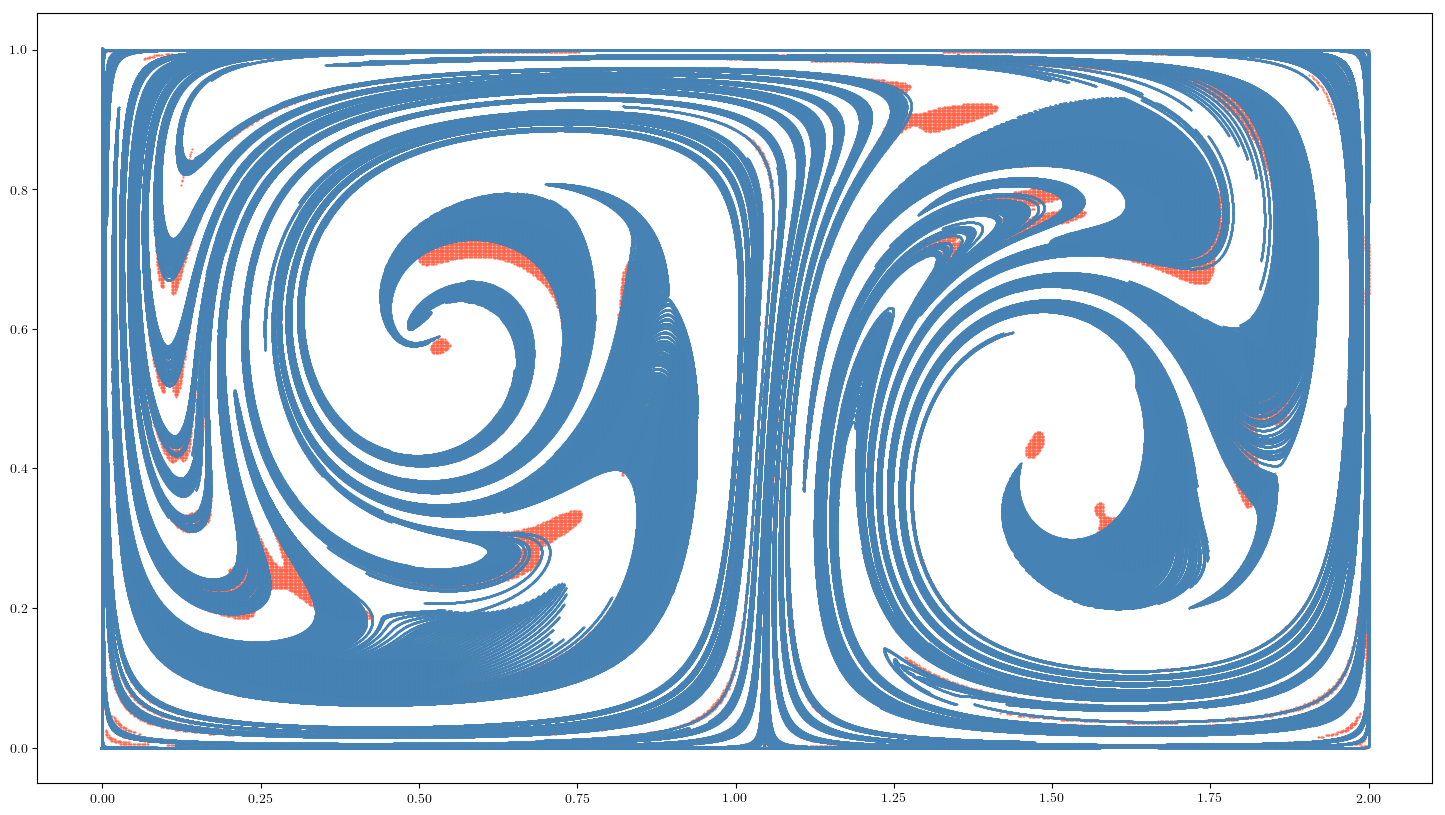

In [173]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for strainline in strainlines:
    plt.scatter(strainline.traj()[0],strainline.traj()[1],s=1,c='steelblue',marker='.')

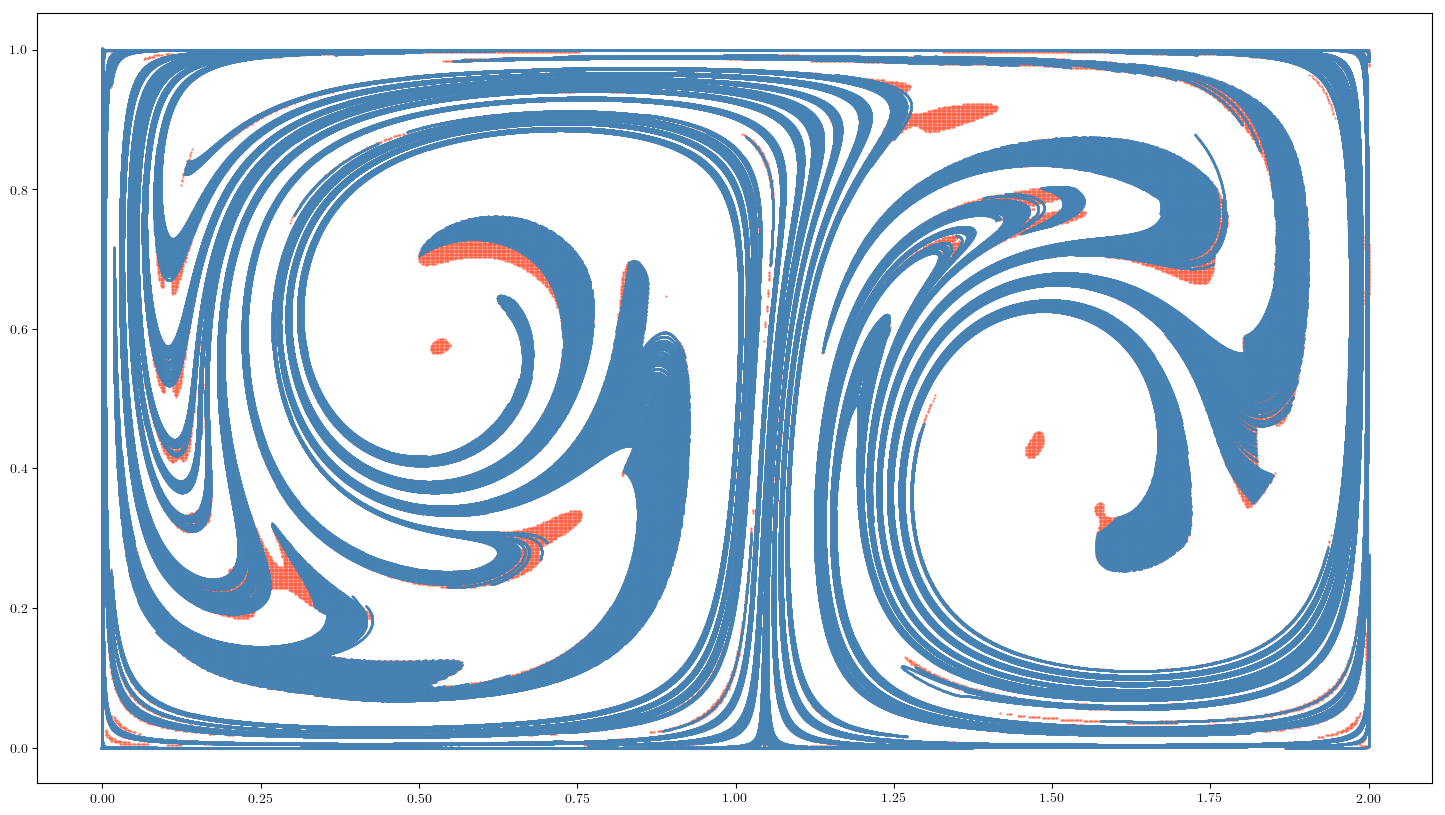

In [172]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for strainline in strainlines:
    plt.scatter(strainline.tailcut_traj()[0],strainline.tailcut_traj()[1],s=1,c='steelblue',marker='.')

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
num = 1
plt.scatter(strainlines[num].pos[0],strainlines[num].pos[1],s=1,c='steelblue',marker='.')

In [ ]:
strainlines[0].tailcut_end

In [117]:
np.size(strainlines)
ensure_path_exists('precomputed_strainlines/{}'.format(integrator.__name__))
np.save('precomputed_strainlines/{}/nx={}_ny={}_t_start={}_t_end={}_h={}__max_iter={}_stride={}_l_f_max={}_tol_alpha={}.npy'.format(integrator.__name__,nx,ny,t_start,t_end,h,max_iter,stride,l_f_max,tol_alpha),strainlines)

# Function which finds the horizontal and vertical lines in $\mathcal{L}$

In [ ]:
def find_vert_and_horz_lines_in_L(x_min,x_max,y_min,y_max,num_horz,num_vert):
    stride_horz = (x_max-x_min)/(num_vert+1)
    stride_vert = (y_max-y_min)/(num_horz+1)
    
    vert_x = np.empty(num_vert)
    horz_y = np.empty(num_horz)
    
    for j in range(num_vert):
        vert_x[j] = (j+1)*stride_horz
    
    for j in range(num_horz):
        horz_y[j] = (j+1)*stride_vert
        
    return vert_x, horz_y

# Function identifying intersections between strainlines and $\mathcal{L}$

In [ ]:
def find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz,num_vert):
    vert_x,horz_y = find_vert_and_horz_lines_in_L(x_min,x_max,y_min,y_max,num_horz,num_vert)
    n_strainlines = len(strainlines)
    isect_horz = [[[[],[]] for i in range(num_horz)] for j in range(n_strainlines)]
    isect_vert = [[[[],[]] for i in range(num_vert)] for j in range(n_strainlines)]
    tic = time.time()
    for i in range(n_strainlines):
        traj = strainlines[i].pos
        for j in range(num_horz):
            for k in range(np.size(traj,1)-1):
                if (traj[1,k]-horz_y[j])*(traj[1,k+1]-horz_y[j])<=0:
                    wk = (traj[1,k+1]-horz_y[j])/(traj[1,k+1]-traj[1,k])
                    isect_horz[i][j][0].append(wk*traj[0,k]+(1-wk)*traj[0,k+1])
                    isect_horz[i][j][1].append(horz_y[j])
        for j in range(num_vert):
            for k in range(np.size(traj,1)-1):
                if (traj[0,k]-vert_x[j])*(traj[0,k+1]-vert_x[j])<=0:
                    wk = (traj[0,k+1]-vert_x[j])/(traj[0,k+1]-traj[0,k])
                    isect_vert[i][j][0].append(vert_x[j])
                    isect_vert[i][j][1].append(wk*traj[1,k]+(1-wk)*traj[1,k+1]) 
    mins,secs = np.divmod(time.time()-tic,60)
    print('Intersections found in {} minutes and {} seconds'.format(mins,secs))
    return isect_horz,isect_vert

# Find aforementioned intersections

In [ ]:
num_vert_comp = 7
num_horz_comp = 7

vert_x, horz_y = find_vert_and_horz_lines_in_L(x_min,x_max,y_min,y_max,num_horz_comp,num_vert_comp)
isect_horz,isect_vert = find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz_comp,num_vert_comp)

# Functions which find sufficiently close neighboring strainlines near intersections

In [ ]:
def find_neighbors(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n_proc=4):
    div = np.floor(np.linspace(0,len(strainlines),n_proc+1)).astype(int)
    queues = [mp.Queue() for j in range(n_proc)]
    processes = [mp.Process(target=_find_neighbors,
                           args=(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,
                                l_n,div[j],div[j+1],j,queues[j]))
                for j in range(n_proc)]
    nbrs_vert = []
    nbrs_horz = []
    tic = time.time()
    for process in processes:
        process.start()
    for q in queues:
        nbrs_vert += q.get()
        nbrs_horz += q.get()
    for process in processes:
        process.join()
    mins,secs = np.divmod(time.time()-tic,60)
    print('Neighbors found in {} minutes and {} seconds'.format(mins,secs))
    return nbrs_vert,nbrs_horz

def _find_neighbors(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n0,nend,pn,q):
    n_strainlines = len(strainlines)
    nbrs_vert = []
    nbrs_horz = []
    for i in range(n0,nend):
        nbrs_strline_vert = []
        for j in range(num_vert):
            nbrs_vert_isect = [[] for k in range(len(intersections_vert[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_vert[i][j][0])):
                    for n in range(len(intersections_vert[k][j][0])):
                        if k!=i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][n]) < l_n:
                            nbrs_vert_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_vert[i][j][0]),np.size(intersections_vert[k][j][0]))):
                #    if k != i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][m]) < l_n:
                #        nbrs_vert_isect[m].append(k)
            nbrs_strline_vert.append(nbrs_vert_isect)
        nbrs_vert.append(nbrs_strline_vert)
        
        nbrs_strline_horz = []
        for j in range(num_horz):
            nbrs_horz_isect = [[] for k in range(len(intersections_horz[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_horz[i][j][0])):
                    for n in range(len(intersections_horz[k][j][0])):
                        if k!=i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][n]) < l_n:
                            nbrs_horz_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_horz[i][j][0]),np.size(intersections_horz[k][j][0]))):
                #    if k != i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][m]) < l_n:
                #        nbrs_horz_isect[m].append(k)
            nbrs_strline_horz.append(nbrs_horz_isect)
        nbrs_horz.append(nbrs_strline_horz)
        if not np.mod(i+1-n0,np.floor((nend-n0)/4).astype(int)):
            print('Process {}: Found neighbors for {} of {} strainlines'.format(pn,i+1-n0,nend-n0))
    q.put(nbrs_vert)
    q.put(nbrs_horz)

# Identify aforementioned neighbors

In [ ]:
l_n = 0.2

nbrs_vert,nbrs_horz = find_neighbors(strainlines,num_horz_comp,num_vert_comp,isect_horz,isect_vert,l_n)

# Function which identifies LCSs based on comparisons of neighboring strainlines

In [ ]:
#@njit
def findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz,num_vert):
    LCSindxs = []
    progressbar = FloatProgress(min=0,max=len(strainlines))
    display(progressbar)
    lmbd2_avgs = [strainline.avg_lmbd2() for strainline in strainlines]
    for i, (strainline,lmbd2_avg) in enumerate(zip(strainlines,lmbd2_avgs)):
        if not np.mod(i+1,10):
            progressbar.value+=10
        for j in range(num_vert):
            for k in range(len(nbrs_vert[i][j])):
                nbr_indxs = set(nbrs_vert[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if (np.size(T) > 0 and lmbd2_avg >= np.amax(T) and strainline.long_enough()):
                    LCSindxs.append(i)
                    
        for j in range(num_horz):
            for k in range(len(nbrs_horz[i][j])):
                nbr_indxs = set(nbrs_horz[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if (np.size(T) > 0 and lmbd2_avg >= np.amax(T) and strainline.long_enough()):
                    LCSindxs.append(i)
    LCSindxs = list(set(LCSindxs))
    LCSs = []
    for ind in LCSindxs:
        LCSs.append(strainlines[ind])
        print('Strainline {} is an LCS!'.format(ind))
    return LCSs

# Identifying LCSs:

In [ ]:
LCSs = findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz_comp,num_vert_comp)

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
nmn = 411
plt.scatter(strainlines[nmn].pos[0],strainlines[nmn].pos[1],c='steelblue',s=1,marker='.')

In [ ]:
strainlines[nmn].avg_lmbd2()

In [ ]:
len(strainlines)

# Plot LCSs

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for LCS in LCSs:
    plt.scatter(LCS.pos[0],LCS.pos[1],c='k',s=1,marker='.')

In [ ]:
#np.save('../../vilje_pyscripts/grid_nx=1000_ny=500.npy',grid)
#np.save('../../vilje_pyscripts/lmbd1_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',lmbd1)
#np.save('../../vilje_pyscripts/lmbd2_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',lmbd2)
#np.save('../../vilje_pyscripts/lapl_lmbd2_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',lapl_lmbd2)
#np.save('../../vilje_pyscripts/xi1_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',xi1)
#np.save('../../vilje_pyscripts/xi2_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',xi2)
#np.save('../../vilje_pyscripts/lapl_xi2_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',xi2)
#np.save('../../vilje_pyscripts/g0_nx=1000_ny=500_t_start=0._t_end=20._h=0.1.npy',g0)

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for strainline in strainlines:
    plt.scatter(strainline.pos[0,:strainline.startpoint_index],strainline.pos[1,:strainline.startpoint_index],s=1,c='steelblue',marker='.')
    plt.scatter(strainline.pos[0,strainline.startpoint_index:],strainline.pos[1,strainline.startpoint_index:],s=1,c='darkgreen',marker='.')

In [ ]:
maxlen

In [ ]:
counter = 0
indxs = []
for i,strainline in enumerate(strainlines):
    if np.any(strainline.max_iter):
        counter+=1
        indxs.append(i)

In [ ]:
counter
indxs

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for ind in indxs:
    print(strainlines[ind].pos.shape)
    plt.scatter(strainlines[ind].pos[0,:strainlines[ind].startpoint_index],strainlines[ind].pos[1,:strainlines[ind].startpoint_index],s=1,c='steelblue',marker='.')
    plt.scatter(strainlines[ind].pos[0,strainlines[ind].startpoint_index:],strainlines[ind].pos[1,strainlines[ind].startpoint_index:],s=1,c='limegreen',marker='.')

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
plt.scatter(strainlines[indxs[j]].pos[0],strainlines[indxs[j]].pos[1],c='steelblue',s=1,marker='.')

In [ ]:
a = np.array([[[0,1],[2,3]],[[4,5],[6,7]],[[8,9],[10,11]]])

In [ ]:
a

In [ ]:
a.shape

In [ ]:
np.sqrt((np.diff(strainlines[1].pos,axis=1)**2).sum(axis=0))

In [ ]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for strainline in strainlines:
    plt.scatter(strainline.pos[0],strainline.pos[1],s=1,marker='.',c='steelblue')

In [ ]:
class InABDomain:
    def __init__(self,pos_init,lmbd1,lmbd2,hess_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_xx_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,0,0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_xy_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,0,1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_yx_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,1,0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._hess_lmbd2_yy_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],hess_lmbd2[:,:,1,1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[:,:,0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[:,:,1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        
    def __call__(self,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        hess = np.array([[self._hess_lmbd2_xx_spline.ev(pos[1],pos[0]),self._hess_lmbd2_xy_spline.ev(pos[1],pos[0])],[self._hess_lmbd2_yx_spline.ev(pos[1],pos[0]),self._hess_lmbd2_yy_spline.ev(pos[1],pos[0])]])
        xi2 = np.array([self._xi2_x_spline.ev(pos[1],pos[0]),self._xi2_y_spline.ev(pos[1],pos[0])])
        #xi2 = xi2/np.sqrt(xi2[0]**2+xi2[1]**2)
        return ((lmbd1 != lmbd2) and (lmbd2 > 1) and np.less_equal(np.dot(xi2,np.dot(hess,xi2)),0))

In [ ]:
padding_factor = 0.01

In [ ]:
in_AB_domain = InABDomain(np.reshape(grid,(2,nx,ny)),np.reshape(lmbd1,(nx,ny)),np.reshape(lmbd2,(nx,ny)),np.reshape(hess_lmbd2,(nx,ny,2,2)),np.reshape(xi2,(nx,ny,2)),x_min,x_max,y_min,y_max,padding_factor)
msk_ba = np.zeros(grid.shape[1],dtype=np.bool)
for j in range(grid.shape[1]):
    msk_ba[j] = in_AB_domain(grid[:,j])

In [ ]:
plt.scatter(grid[0,msk_ba],grid[1,msk_ba],s=1,c='tomato',marker='.')

In [ ]:
plt.pcolormesh(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],np.log(lmbd2.reshape(nx,ny).T))
plt.plot([0.22,0.22],[0,1],c='tomato')

In [ ]:
def find_vert_and_horz_lines_in_L2(x_min,x_max,y_min,y_max,num_horz,num_vert):
    stride_horz = (x_max-x_min)/(num_vert+1)
    stride_vert = (y_max-y_min)/(num_horz+1)
    
    vert_x = np.empty(num_vert)
    horz_y = np.empty(num_horz)
    
    for j in range(num_vert):
        vert_x[j] = (j+1)*stride_horz
    
    for j in range(num_horz):
        horz_y[j] = (j+1)*stride_vert
        
    return vert_x, horz_y

In [175]:
def find_intersections2(strainlines,x_min,x_max,y_min,y_max,num_horz,num_vert,vert_x,horz_y):
    n_strainlines = len(strainlines)
    isect_horz = [[[[],[]] for i in range(num_horz)] for j in range(n_strainlines)]
    isect_vert = [[[[],[]] for i in range(num_vert)] for j in range(n_strainlines)]
    tic = time.time()
    for i in range(n_strainlines):
        traj = strainlines[i].tailcut_traj()
        for j in range(num_horz):
            for k in range(np.size(traj,1)-1):
                if (traj[1,k]-horz_y[j])*(traj[1,k+1]-horz_y[j])<=0:
                    wk = (traj[1,k+1]-horz_y[j])/(traj[1,k+1]-traj[1,k])
                    isect_horz[i][j][0].append(wk*traj[0,k]+(1-wk)*traj[0,k+1])
                    isect_horz[i][j][1].append(horz_y[j])
        for j in range(num_vert):
            for k in range(np.size(traj,1)-1):
                if (traj[0,k]-vert_x[j])*(traj[0,k+1]-vert_x[j])<=0:
                    wk = (traj[0,k+1]-vert_x[j])/(traj[0,k+1]-traj[0,k])
                    isect_vert[i][j][0].append(vert_x[j])
                    isect_vert[i][j][1].append(wk*traj[1,k]+(1-wk)*traj[1,k+1]) 
    mins,secs = np.divmod(time.time()-tic,60)
    print('Intersections found in {} minutes and {} seconds'.format(mins,secs))
    return isect_horz,isect_vert

In [176]:
def find_neighbors2(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n_proc=4):
    div = np.floor(np.linspace(0,len(strainlines),n_proc+1)).astype(int)
    queues = [mp.Queue() for j in range(n_proc)]
    processes = [mp.Process(target=_find_neighbors2,
                           args=(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,
                                l_n,div[j],div[j+1],j,queues[j]))
                for j in range(n_proc)]
    nbrs_vert = []
    nbrs_horz = []
    tic = time.time()
    for process in processes:
        process.start()
    for q in queues:
        nbrs_vert += q.get()
        nbrs_horz += q.get()
    for process in processes:
        process.join()
    mins,secs = np.divmod(time.time()-tic,60)
    print('Neighbors found in {} minutes and {} seconds'.format(mins,secs))
    return nbrs_vert,nbrs_horz

def _find_neighbors2(strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n0,nend,pn,q):
    n_strainlines = len(strainlines)
    nbrs_vert = []
    nbrs_horz = []
    for i in range(n0,nend):
        nbrs_strline_vert = []
        for j in range(num_vert):
            nbrs_vert_isect = [[] for k in range(len(intersections_vert[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_vert[i][j][0])):
                    for n in range(len(intersections_vert[k][j][0])):
                        if k!=i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][n]) < l_n:
                            nbrs_vert_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_vert[i][j][0]),np.size(intersections_vert[k][j][0]))):
                #    if k != i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][m]) < l_n:
                #        nbrs_vert_isect[m].append(k)
            nbrs_strline_vert.append(nbrs_vert_isect)
        nbrs_vert.append(nbrs_strline_vert)
        
        nbrs_strline_horz = []
        for j in range(num_horz):
            nbrs_horz_isect = [[] for k in range(len(intersections_horz[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_horz[i][j][0])):
                    for n in range(len(intersections_horz[k][j][0])):
                        if k!=i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][n]) < l_n:
                            nbrs_horz_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_horz[i][j][0]),np.size(intersections_horz[k][j][0]))):
                #    if k != i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][m]) < l_n:
                #        nbrs_horz_isect[m].append(k)
            nbrs_strline_horz.append(nbrs_horz_isect)
        nbrs_horz.append(nbrs_strline_horz)
        if not np.mod(i+1-n0,np.floor((nend-n0)/4).astype(int)):
            print('Process {}: Found neighbors for {} of {} strainlines'.format(pn,i+1-n0,nend-n0))
    q.put(nbrs_vert)
    q.put(nbrs_horz)

In [187]:
#@njit
def findLCSs2(strainlines,nbrs_horz,nbrs_vert,num_horz,num_vert):
    LCSindxs = []
    progressbar = FloatProgress(min=0,max=len(strainlines))
    display(progressbar)
    lmbd2_avgs = [strainline.tailcut_avg_lmbd2() for strainline in strainlines]
    #lmbd2_avgs = [strainline.avg_lmbd2() for strainline in strainlines]
    lngths = [strainline.tailcut_lngth() for strainline in strainlines]
    for i, (strainline,lmbd2_avg,lngth) in enumerate(zip(strainlines,lmbd2_avgs,lngths)):
        if not np.mod(i+1,10):
            progressbar.value+=10
        for j in range(num_vert):
            for k in range(len(nbrs_vert[i][j])):
                nbr_indxs = set(nbrs_vert[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if np.size(T) > 0 and lmbd2_avg >= np.amax(T) and lngth >= strainline.l_min:
                    LCSindxs.append(i)
                    
        for j in range(num_horz):
            for k in range(len(nbrs_horz[i][j])):
                nbr_indxs = set(nbrs_horz[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                #if (np.size(T) > 0 and lmbd2_avg >= np.amax(T) and strainline.long_enough()):
                if np.size(T) > 0 and lmbd2_avg >= np.amax(T) and lngth >= strainline.l_min:
                    LCSindxs.append(i)
    LCSindxs = list(set(LCSindxs))
    LCSs = []
    for ind in LCSindxs:
        LCSs.append(strainlines[ind])
        print('Strainline {} is an LCS!'.format(ind))
    return LCSs

In [178]:
num_vert_comp2 = 3
num_horz_comp2 = 3

vert_x2 = np.array([0.15,1.05,1.95])
horz_y2 = np.array([0.1,0.5,0.9])

#vert_x2,horz_y2 = find_vert_and_horz_lines_in_L2(x_min,x_max,y_min,y_max,num_vert_comp2,num_horz_comp2)
isect_horz2,isect_vert2 = find_intersections2(strainlines,x_min,x_max,y_min,y_max,num_horz_comp2,num_vert_comp2,vert_x2,horz_y2)

l_n = 0.3

nbrs_vert2,nbrs_horz2 = find_neighbors2(strainlines,num_horz_comp2,num_vert_comp2,isect_horz2,isect_vert2,l_n)

Intersections found in 0.0 minutes and 57.7889666557312 seconds
Process 3: Found neighbors for 92 of 368 strainlines
Process 1: Found neighbors for 92 of 368 strainlines
Process 0: Found neighbors for 91 of 367 strainlines
Process 1: Found neighbors for 184 of 368 strainlines
Process 2: Found neighbors for 91 of 367 strainlines
Process 1: Found neighbors for 276 of 368 strainlines
Process 3: Found neighbors for 184 of 368 strainlines
Process 2: Found neighbors for 182 of 367 strainlines
Process 3: Found neighbors for 276 of 368 strainlines
Process 1: Found neighbors for 368 of 368 strainlines
Process 0: Found neighbors for 182 of 367 strainlines
Process 0: Found neighbors for 273 of 367 strainlines
Process 2: Found neighbors for 273 of 367 strainlines
Process 3: Found neighbors for 368 of 368 strainlines
Process 0: Found neighbors for 364 of 367 strainlines
Process 2: Found neighbors for 364 of 367 strainlines
Neighbors found in 0.0 minutes and 37.91312789916992 seconds


In [184]:
LCSs = findLCSs2(strainlines,nbrs_horz2,nbrs_vert2,num_horz_comp2,num_vert_comp2)

FloatProgress(value=0.0, max=1470.0)

Strainline 0 is an LCS!
Strainline 736 is an LCS!
Strainline 746 is an LCS!
Strainline 1458 is an LCS!
Strainline 757 is an LCS!
Strainline 696 is an LCS!
Strainline 346 is an LCS!
Strainline 252 is an LCS!


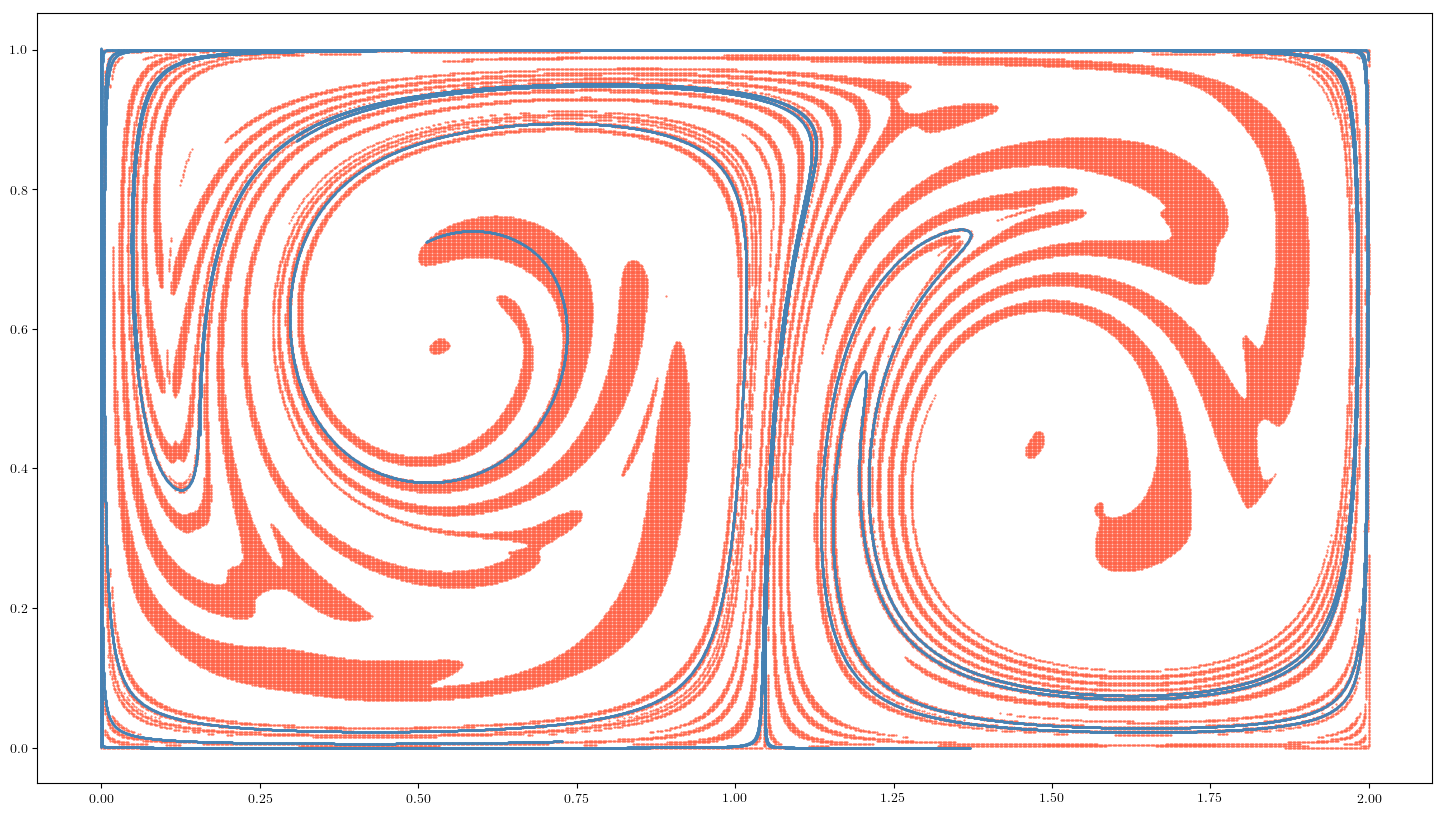

In [186]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for LCS in LCSs:
    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],c='steelblue',s=1,marker='.')

FileNotFoundError: [Errno 2] No such file or directory: 'adve*.npy'